# 2) Relación Entre Viajes En Bicicleta y el Clima

In [165]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
trips = pd.read_csv('data/trip.csv', low_memory=False)
weather = pd.read_csv('data/weather.csv', low_memory=False)
#Se convierte los dates a datetime64[ns].
trips['start_date'] = pd.to_datetime(trips['start_date'])
weather['date'] = pd.to_datetime(weather['date'])

In [167]:
#Se agrega una nueva columna date que coincide con weather.
trips['date'] = trips['start_date'].apply(lambda x: x.date())
#Se convierte date a datetime64[ns].
trips['date'] = pd.to_datetime(trips['date'])

In [168]:
#Se convierte zip_code a string en weather para coincidir con trips.
#NOTA: No se convierte zip_code de trips a int64 por un extraño error en to_numeric.
weather['zip_code'] = weather['zip_code'].astype(str)

In [169]:
#Formula para convertir F a C.
def f_to_c(f_temp):
    return round((f_temp - 32) / 1.8, 2)

In [170]:
#Se crean columnas con las temperaturas en C.
weather['max_temperature_c'] = weather['max_temperature_f'].map(f_to_c)
weather['mean_temperature_c'] = weather['mean_temperature_f'].map(f_to_c)
weather['min_temperature_c'] = weather['min_temperature_f'].map(f_to_c)

In [171]:
#Se crean columnas con visibilidad en Km.
weather['max_visibility_km'] = weather['max_visibility_miles'].map(lambda x: x * 1.6)
weather['mean_visibility_km'] = weather['mean_visibility_miles'].map(lambda x: x * 1.6)
weather['min_visibility_km'] = weather['min_visibility_miles'].map(lambda x: x * 1.6)

In [172]:
#Funcion para convertir la duracion de segundos a minutos.
def s_to_m(time):
    return (time / 60)
#Funcion para convertir la duracion de segundos a horas redondeo a 3 decimales.
def s_to_h(time):
    return round((time / 3600),3)

In [173]:
#Se crea una columna con la duracion en minutos y la duracion en horas.
trips['duration_m'] = trips['duration'].map(s_to_m)
trips['duration_h'] = trips['duration'].map(s_to_h)

In [174]:
#Se filtran las duraciones menores o iguales a 3 minutos con la misma estacion de salida y llegada.
trips = trips[-((trips['duration_m'] <= 3.0) & (trips['start_station_id'] == trips['end_station_id']))]

Este filtrado se realiza porque si el viaje duro menos de 3 minutos y termino en la misma estación que comenzó, entonces se puede pensar que hubo un desperfecto técnico en la bicicleta o que el usuario desistió de realizar el viaje, es decir, el viaje no se concreto.

In [175]:
#Se combinan los Dataframes.
joined = trips.merge(weather, left_on=['date', 'zip_code'], right_on=['date', 'zip_code'])

## 2.1) ¿Como se relacionan los viajes en bicicleta y la temperatura?

En esta serie de plots se analizará si hay una correlación entre los viajes en bicicleta y la temperatura.

Como los registros del clima están en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climáticas para decidir si realizar un viaje o no. 

### 2.1.A) Histograma del Promedio de Temperatura

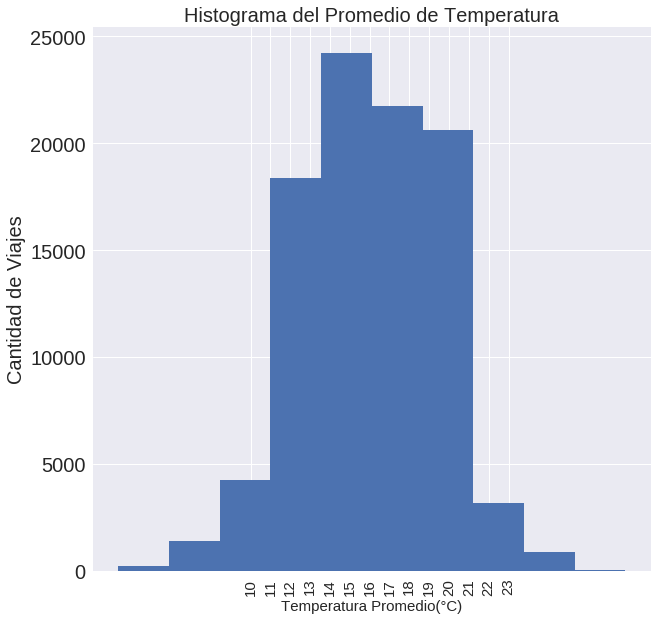

In [264]:
joined.hist(column='mean_temperature_c', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(10,24,1));
plt.xlabel('Temperatura Promedio(°C)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma del Promedio de Temperatura', fontsize=20);

En este histograma se puede apreciar que la mayor cantidad de los viajes se realizan cuando la temperatura promedio esta entre 12°C y 21°C.  
Si bien puede parecer que la temperatura es algo baja, hay que tener en cuenta que esto es un promedio de la temperatura de todo el día y como San Francisco es una ciudad costera la temperatura suele bajar bastante sobre la noche.

### 2.1.B) Histograma de la Temperatura Máxima

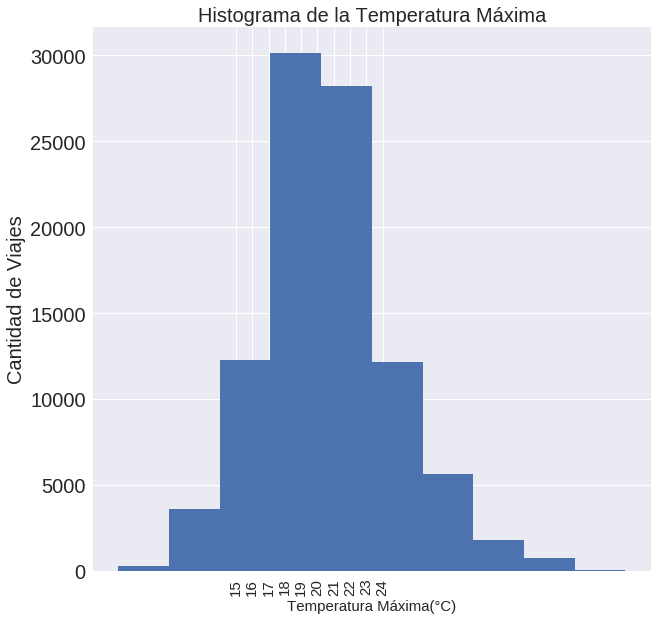

In [263]:
joined.hist(column='max_temperature_c', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(15,25,1));
plt.xlabel('Temperatura Máxima(°C)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de la Temperatura Máxima', fontsize=20);

De este histograma se puede obtener que la mayoria de los viajes se realizan cuando la temperatura maxima esta entre 18°C y 23°C.

Si se toman en cuenta los dos histogramas en conjunto, se puede apreciar que la mayoría de las personas buscan temperaturas templadas a la hora de realizar los viajes.  
No es necesario analizar la temperatura mínima, ya que como se dijo antes, la temperatura suele bajar mucho sobre la noche y daría resultados engañosos.

### 2.1.C) Dias con mayor uso simultaneo de Bicicletas y la Temperatura

In [178]:
#Funciones para clasificar.
def f_st(row):
    if row['event'] == 'start_date':
        val = 1
    else:
        val = 0
    return val

def f_en(row):
    if row['event'] == 'end_date':
        val = 1
    else:
        val = 0
    return val

In [179]:
trips_aux = trips[['id', 'start_date', 'end_date', 'zip_code']]
trips_melt = pd.melt(trips_aux, id_vars=['id','zip_code'], value_vars=['start_date', 'end_date'], var_name='event', value_name='time')
trips_melt['time'] = pd.to_datetime(trips_melt['time'])

In [180]:
#Se obtiene la cantidad de bicicletas en uso al mismo tiempo.
trips_ord = trips_melt.sort_values('time', ascending=True) 
trips_ord['start_counter'] = trips_ord.apply(f_st, axis=1)
trips_ord['end_counter'] = trips_ord.apply(f_en, axis=1)
trips_ord['start'] = trips_ord['start_counter'].cumsum()
trips_ord['end'] = trips_ord['end_counter'].cumsum()
trips_ord = trips_ord[['id', 'zip_code', 'time', 'start', 'end']]
trips_ord['in_use'] = trips_ord['start'] - trips_ord['end']
trips_ord = trips_ord.sort_values('in_use', ascending=False)

In [181]:
#Se eliminan los horarios para coincidir con weather.csv.
trips_ord['time'] = trips_ord['time'].apply(lambda x: x.date())
#Se convierte time a datetime64[ns].
trips_ord['time'] = pd.to_datetime(trips_ord['time'])

In [182]:
#Se combinan los Dataframes.
joined_simul = trips_ord.merge(weather, left_on=['time', 'zip_code'], right_on=['date', 'zip_code'])

In [183]:
#Solo hay que quedarse con el maximo de bicicletas simultaneas para ese dia.
joined_max_simul = joined_simul.drop_duplicates(subset=['time'], keep='first')

In [184]:
#Nos quedamos con los 10 valores maximos y las columnas que interesan.
joined_max_simul_bar = joined_max_simul[:10]
joined_max_simul_bar = joined_max_simul_bar[['time', 'mean_temperature_c', 'max_temperature_c']]
joined_max_simul_bar.set_index('time', inplace=True)

En el siguiente gráfico de barras se pueden aprecian los 10 días (de los cuales hay datos de temperatura) con mayor uso simultaneo de bicicletas(ordenados de forma descendente), junto con su temperatura promedio y temperatura máxima. La locación tomada para el clima de cada día, es donde se produce su respectivo pico máximo de bicicletas en uso.

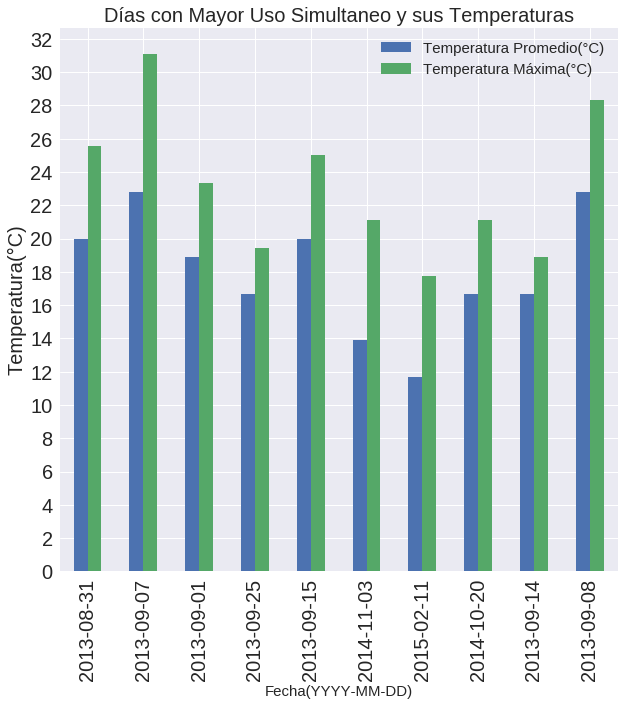

In [260]:
bar = joined_max_simul_bar.plot.bar(figsize=(10,10), fontsize=20);
#Elimina el 00:00:00 del plot.
bar.set_xticklabels(joined_max_simul_bar.index.format());
plt.yticks(range(0,33,2));
plt.xlabel('Fecha(YYYY-MM-DD)', fontsize=15);
plt.ylabel('Temperatura(°C)', fontsize=20);
plt.title('Días con Mayor Uso Simultaneo y sus Temperaturas', fontsize=20);
plt.legend(['Temperatura Promedio(°C)', 'Temperatura Máxima(°C)'], fontsize=15);

Primero es interesante notar que los dos primeros días tienen dos de las mayores temperaturas máximas, 26°C y 31°C respectivamente, pero el ultimo día no tiene la temperatura mas fría, por el contrario tiene una de las temperaturas máximas mas altas, 28°C.  
El segundo punto importante a notar es que la mayoría de estos días tienen temperaturas templadas, es decir, sus temperaturas promedio varían entre 12°C y 23°C mientras que sus temperaturas máximas están entre 18 y 26°C.  
Por ultimo, es evidente que si bien la cantidad de bicicletas en uso simultáneamente decrece a lo largo del gráfico de barras, las temperaturas se mantienen siempre dentro de un mismo rango.

### 2.1.D) Conclusión de Viajes y Temperatura

Usando los plots anteriores se puede concluir que la mayor cantidad de viajes se realizan cuando la temperatura es templada, es decir, cuando esta alrededor de los 25°C.
Para describir este fenómeno hay que tener en cuenta los motivos por los cuales se podría realizar un viaje, para simplificar se tomaran dos casos:
1. En el caso de que se quiera realizar un viaje por la necesidad de trasladarse, la temperatura no afecta mucho, excepto en casos de muy bajas o muy altas temperaturas.
2. El caso en el cual se quiere realizar un viaje por placer es el que interesa, ya que es aquí cuando la temperatura juega un rol importante. Con temperaturas templadas las personas estarán mas predispuestas a realizar viajes en bicicleta, como muestran los plots obtenidos. 

Por ultimo, es importante notar que las mejores temperaturas se suelen presentar sobre la tarde, ya que es cuando comienza a bajar el sol, por eso no seria extraño que la mayor cantidad de los viajes se realicen en horarios de la tarde.

## 2.2) ¿Como se relacionan los viajes y la visibilidad?

En la siguiente serie de plots se tratara de analizar si hay una correlación entre los viajes en bicicletas y la visibilidad.  

Como los registros del clima están en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climáticas para decidir si realizar un viaje o no. 

### 2.2.A)  Grafico de Barras de Visibilidad Promedio y Histograma de Visibilidad Promedio

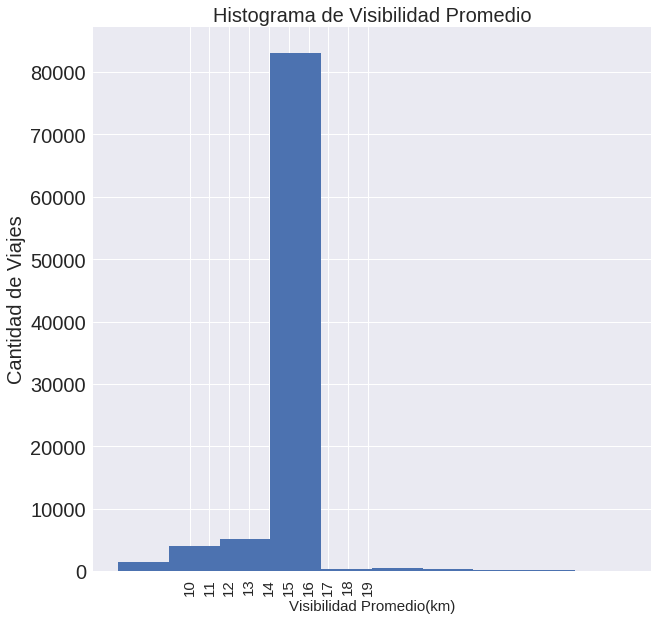

In [266]:
joined.hist(column='mean_visibility_km', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(10,20,1));
plt.xlabel('Visibilidad Promedio(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de Visibilidad Promedio', fontsize=20);

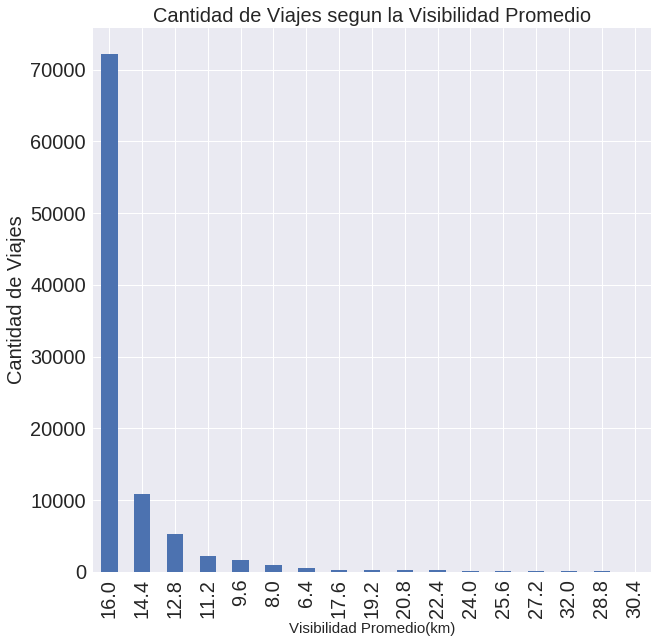

In [283]:
joined['mean_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Promedio(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Promedio', fontsize=20);

De este plot se pueden extraer tres puntos importantes:  
* La mayoría de los viajes en bicicleta se realizan cuando la visibilidad promedio esta entre 14.4km y 16km, mas precisamente cuando esta en 16km.
* Por encima de los 16km de visibilidad promedio hay escasez de datos, por lo tanto, se puede intuir que no es normal que en San Francisco se presenten visibilidades promedio tan elevadas.  
* Sino se toman en cuenta las visibilidades promedio mayores a 16km(porque no hay datos suficientes), la diferencia entre las visibilidades promedio mayores o iguales a 14.4km y las menores a esta es abismal. Esto no es un dato menor, ya que hay que tener una buena visibilidad al realizar un viaje para que este sea seguro y queda claro, por esta diferencia, que el usuario prioriza mucho la seguridad.

Ahora seria importante analizar que sucede con la visibilidad mínima, ya que por cuestiones de seguridad es importante que haya una buena visibilidad mínima para evitar accidentes.

### 2.2.B) Grafico de Barras de Visibilidad Mínima y Histograma de Visibilidad Mínima

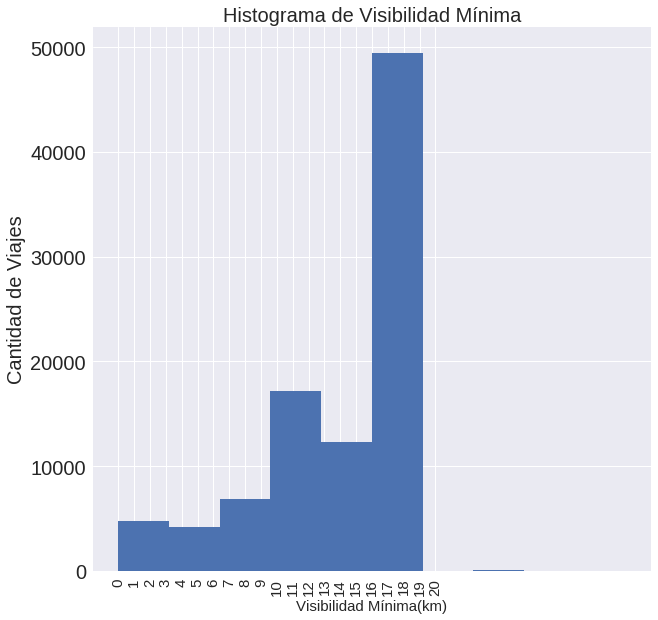

In [270]:
joined.hist(column='min_visibility_km', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(0,21,1));
plt.xlabel('Visibilidad Mínima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de Visibilidad Mínima', fontsize=20);

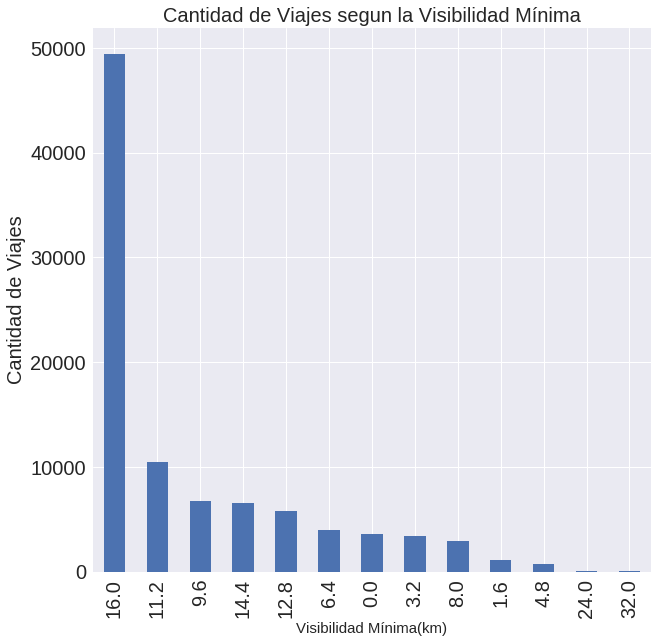

In [284]:
joined['min_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Mínima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Mínima', fontsize=20);

En estos dos plots se apreciar de nuevo que la mayor cantidad de viajes se realiza cuando la visibilidad mínima es de 16km. Ademas es importante notar que de nuevo se manifiesta la gran separación entre la visibilidad de 16km y las que son menores a esta. Por ejemplo, si tomamos la visibilidad mínima de 11.2km podemos ver que hay una diferencia aproximada de 40000 viajes con la visibilidad de 16km

### 2.2.C) Grafico de Barras de Visibilidad Máxima

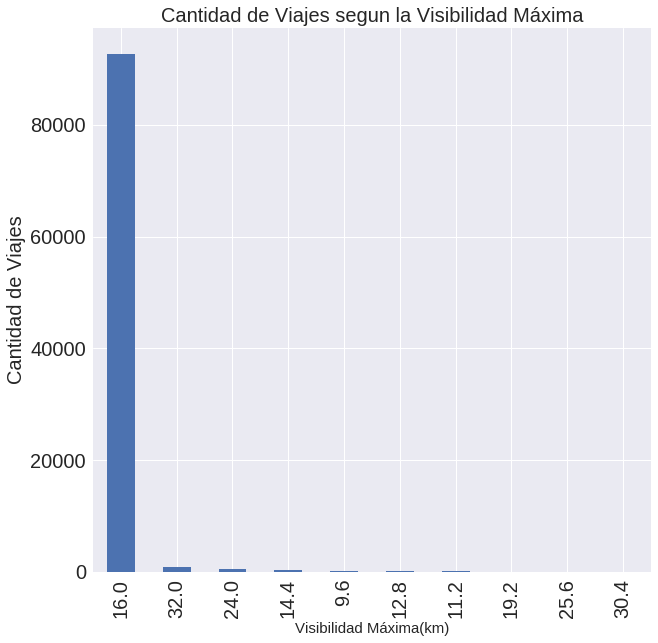

In [285]:
joined['max_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Máxima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Máxima', fontsize=20);

De este plot es muy difícil sacar conclusiones ya que la diferencia de la visibilidad máxima de 16km con las demás es demasiado grande. Lo único importante a destacar, es que no hay ningún valor de visibilidad máxima menor a 9.6km, lo cual indicaría que nunca hay visibilidades máximas menores a 9.6km, lo cual es poco probable, o bien que no se realizan viajes cuando la visibilidad máximas son tan bajas.

### 2.D) Dias con mayor uso simultaneo de Bicicletas y la Visibilidad

In [191]:
#Nos quedamos con los 10 valores maximos y las columnas que interesan.
joined_max_simul_vis_bar = joined_max_simul[:10]
joined_max_simul_vis_bar = joined_max_simul_vis_bar[['time', 'mean_visibility_km', 'min_visibility_km', 'max_visibility_km']]
joined_max_simul_vis_bar.set_index('time', inplace=True)

En el siguiente gráfico de barras se pueden aprecian los 10 días (de los cuales hay datos de temperatura) con mayor uso simultaneo de bicicletas(ordenados de forma descendente), junto con su visibilidad promedio, visibilidad mínima y visibilidad máxima. La locación tomada para el clima de cada día, es donde se produce su respectivo pico máximo de bicicletas en uso.

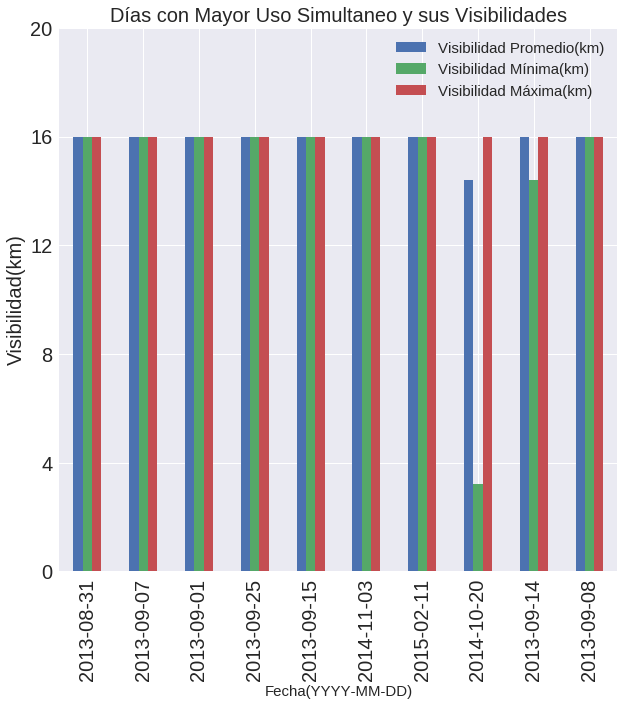

In [298]:
bar = joined_max_simul_vis_bar.plot.bar(figsize=(10,10), fontsize=20);
#Elimina el 00:00:00 del plot.
bar.set_xticklabels(joined_max_simul_vis_bar.index.format());
plt.yticks(range(0,23,4));
plt.xlabel('Fecha(YYYY-MM-DD)', fontsize=15);
plt.ylabel('Visibilidad(km)', fontsize=20);
plt.title('Días con Mayor Uso Simultaneo y sus Visibilidades', fontsize=20);
plt.legend(['Visibilidad Promedio(km)', 'Visibilidad Mínima(km)', 'Visibilidad Máxima(km)'], fontsize=15);

Este plot confirma la tendencia que se había marcado previamente, los 10 dias con mayor uso simultaneo de bicicletas presentan una visibilidad promedio igual o cercana a los 16km. Ademas la mayoría presentan visibilidades mínimas y máximas también de 16km.  
El único caso llamativo es del dia 2014-10-20 en el cual la visibilidad mínima es de 3km, pero si bien su visibilidad mínima es baja su visibilidad máxima y visibilidad promedia se mantienen dentro de lo esperado. Esto nos indicaría que la mayor cantidad de viajes de ese día se habría producido en horarios donde la visibilidad era más cercana a la máxima que a la mínima.

### 2.2.E) Conclusión de Viajes y Visibilidad

Dados los plots vistos se puede concluir claramente que la visibilidad máxima, mínima y mediana deben ser de, o al menos cercano a, 16km para que se produzca un mayor uso del servicio de bicicletas. Esto claramente esta relacionado, como ya se menciono antes, con la seguridad, los usuarios ponen a la seguridad como uno de los puntos más importantes a la hora de decidir si realizar un viaje en bicicleta o no. Por ejemplo, nadie realizaría un viaje bicicleta cuando hay niebla(evento en el cual hay una visibilidad muy baja) porque eso conllevaría un riesgo importante. 

## 2.3) ¿Como se relacionan los viajes y las estaciones climáticas?

### 2.3.A) Cantidad de Viajes y Estaciones Climáticas

En la siguiente serie de plots se analizará si hay una relación entre los viajes en bicicleta y las estaciones climáticas.

In [193]:
#Funcion para clasificar estaciones climaticas.
def estacion(date):
    if date.month >= 3 and date.month <= 5:
        return 'Primavera'
    elif date.month >= 6 and date.month <= 8:
        return 'Verano'
    elif date.month >= 9 and date.month <= 11:
        return 'Otoño'
    else:
        return 'Invierno'

In [194]:
#Se crea la columna con la estacion climatica.
joined['estacion_clima'] = joined['date'].map(estacion)

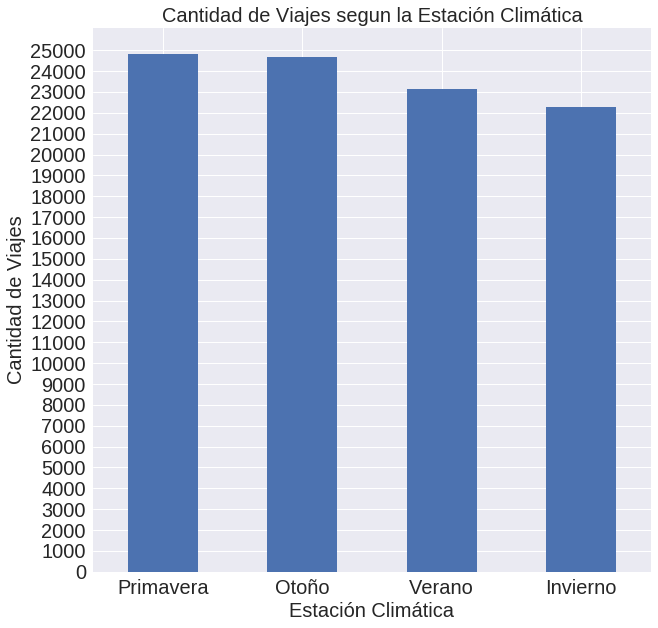

In [288]:
joined['estacion_clima'].value_counts(sort=True).plot.bar(figsize=(10,10), rot=0, fontsize=20);
plt.yticks(range(0,26000,1000));
plt.xlabel('Estación Climática', fontsize=20);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Estación Climática', fontsize=20);

De este plot podemos observar:  
* La mayoría de los viajes se realizan en Primavera, esto concuerda con lo visto en la sección de temperatura ya que en Primavera se presentan temperaturas cercanas a los 25°C.
* La segunda estación climática es el Otoño, esto vuelve a concordar con lo visto en la sección de temperatura ya que, si bien las temperaturas suelen ser mas frías que en Primavera, presenta temperaturas cercanas a los 15°C.
* Por ultimo, es importante notar que todas las estaciones mantienen un piso de 20000 viajes. Esto va de la mano con lo dicho en la sección 2.1.D y 2.2.E, si alguien quiere utilizar el servicio de bicicletas por un motivo no recreativo, no suele darle demasiada importancia a factores climáticos excepto que conlleven un riesgo para su seguridad.

### 2.3.B) Duración promedio de Viajes y Estaciones Climáticas

En este plot se analizará las duraciones promedio de los viajes en cada estación.

In [196]:
grouped_season = joined[['estacion_clima', 'duration_m']].groupby('estacion_clima')\
.aggregate('mean')

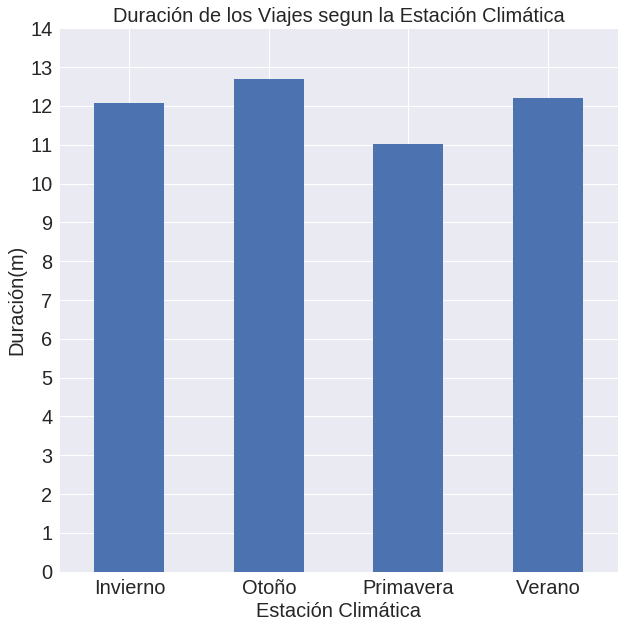

In [294]:
grouped_season.plot.bar(figsize=(10,10), rot=0, fontsize=20);
plt.yticks(range(0,15,1));
plt.xlabel('Estación Climática', fontsize=20);
plt.ylabel('Duración(m)', fontsize=20)
plt.title('Duración de los Viajes segun la Estación Climática', fontsize=20);
plt.legend('');

De este plot podemos hacer dos observaciones importantes:  
* Primero, la Primavera, que tiene la mayor cantidad de viajes, es la que posee la menor duración promedio de viajes.  
* Segundo, todas las estaciones tienen una duración promedio de viajes similares.

### 2.3.C) Conclusión de Viajes y Estaciones Climáticas

La conclusión más importante que se puede obtener de los plots analizados es que la diferencia entre las diferentes estaciones es muy pequeña. Esto se podría deber a los siguientes motivos:  
* Como se expreso anteriormente, todas las estaciones tienen un piso 20000 viajes. Esto da a entender que una gran parte de los usuarios no pone como prioridad al clima a la hora de realizar un viaje, esto se puede deber a que la mayoría de los usuarios utiliza el servicio de bicicletas como modo de transporte y no como en forma recreativa.  
* Si bien los climas varían entre estaciones, los cambios no son tan drásticos como para generar una diferencia sustancial entre la cantidad y duración de viajes en bicicleta entre cada estación.

# 2.4) ¿Que sucede con los 5 viajes de mayor duración?

En los siguientes plots se analizara que sucede con la temperatura, visibilidad y estación climática para los 5 viajes con mayor duración. Se utilizan las duraciones menores o iguales a 12 horas porque se considera que un viaje continuado puede durar, como mucho, 12 horas si se permiten interrupciones de duración corta. Ademas se toman solo los viajes que ocurren durante el día para evitar confusiones con bicicletas que olvidaron entregarse.  
Algunos de los motivos por los cuales se pueden realizar viajes largos son, por ejemplo:  
* Realizar un tour de la ciudad de San Francisco.  
* Realizar actividad física intensiva.
* Tener que realizar varios trayectos en horarios diferentes.

In [198]:
#Se obtienen los 5 viajes con mayor duracion (que poseen datos climaticos) menores a 12 horas
#que ocurran durante el dia (se toman solo viajes que comiencen a la mañana).
joined['start_hour'] = joined['start_date'].map(lambda x: x.hour)
top_dur = joined[(joined['start_hour'] >= 7)  & (joined['start_hour'] <= 11) & (joined['duration_h'] <= 12)]
top_dur = top_dur.sort_values('duration_h', ascending=False)[:5]

### 2.4.A) Temperatura de los 5 Viajes con Mayor Duración

In [199]:
top_dur_temp = top_dur[['duration_h', 'max_temperature_c', 'min_temperature_c', 'mean_temperature_c']]
top_dur_temp.set_index('duration_h', inplace=True)

Se muestran los 5 viajes con mayor duración (con sus respectivas duraciones, en horas, como label) ordenados de forma descendente junto con sus respectivas temperaturas máximas, temperaturas mínimas y temperaturas promedio.

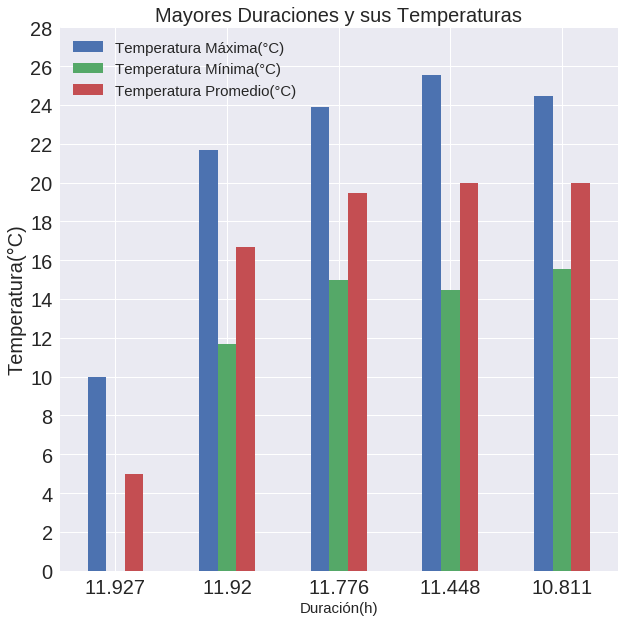

In [301]:
top_dur_temp_bar = top_dur_temp.plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,30,2));
plt.xlabel('Duración(h)', fontsize=15);
plt.ylabel('Temperatura(°C)', fontsize=20);
plt.title('Mayores Duraciones y sus Temperaturas', fontsize=20);
plt.legend(['Temperatura Máxima(°C)', 'Temperatura Mínima(°C)', 'Temperatura Promedio(°C)'], fontsize=15);

De este plot se puede hacer las siguientes observaciones:  
* El viaje con la duración mas larga es también el viaje con las temperaturas mas frías, pero los 4 viajes restantes tienen temperaturas mas cálidas y se ajustan a lo visto en la sección 2.1. Por lo tanto, se puede tomar al primer viaje como una excepción.
* Los 4 viajes con temperaturas cálidas tienen temperaturas muy parecidas.
* Con lo visto en este plot se puede observar que hay una relación entre los viajes de mayor duración y la temperatura, y es que en temperaturas cercanas a los 25°C se producen viajes de mayor duración.

### 2.4.B) Visibilidad de los 5 Viajes con Mayor Duración

In [201]:
top_dur_vis = top_dur[['duration_h', 'max_visibility_km', 'min_visibility_km', 'mean_visibility_km']]
top_dur_vis.set_index('duration_h', inplace=True)

Se muestran los 5 viajes con mayor duración (con sus respectivas duraciones, en horas, como label) ordenados de forma descendente junto con sus respectivas visibilidades máximas, visibilidades mínimas y visibilidades promedio.

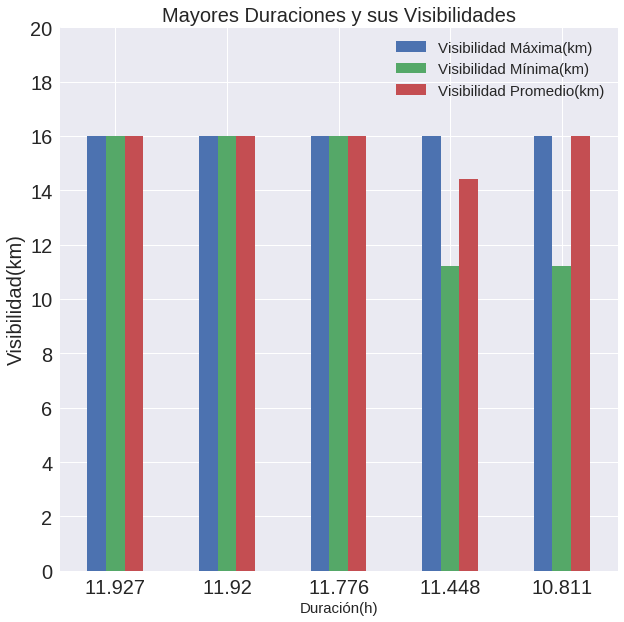

In [305]:
top_dur_vis_bar = top_dur_vis.plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,22,2));
plt.xlabel('Duración(h)', fontsize=15);
plt.ylabel('Visibilidad(km)', fontsize=20);
plt.title('Mayores Duraciones y sus Visibilidades', fontsize=20);
plt.legend(['Visibilidad Máxima(km)', 'Visibilidad Mínima(km)', 'Visibilidad Promedio(km)'], fontsize=15);

En este plot se puede observar que:  
* Todas las visibilidades promedio y visibilidades máximas son iguales o muy cercanas a 16km.  
* Si bien 2 de los 5 viajes tienen visibilidad mínimas menores a 16km nunca llegan a ser menores a 10km.  
* Por lo observado se puede concluir que para que se produzcan viajes de esta duración la visibilidad debe ser muy buena, esto esta acorde con lo dicho en la sección 2.2.
 

### 2.4.C) Estación Climática de los 5 Viajes con Mayor Duracíon

In [203]:
#Se muestran las duracion(en horas) y su respectiva estacion.
top_dur[['duration_h', 'estacion_clima']]

,duration_h,estacion_clima
11085,11.927,Invierno
57906,11.920,Primavera
48689,11.776,Verano
29296,11.448,Verano
46007,10.811,Verano


Las estaciones climáticas de los viajes de mayor duración, ordenados de mayor a menor, son:  
**1.** Invierno  
**2.** Primavera  
**3.** Verano  
**4.** Verano  
**5.** Verano  

Dados estos datos se puede decir que:  
* La mayor duración de los 5 viajes se produce en Invierno y la menor duración de los 5 se produce en Verano.
* La distribución de los viajes es mayor en las estaciones climáticas donde la temperatura se acerca mas a los 25°C (Verano y Primavera).
* Dado esto podemos decir que los viajes de mayor duración se producirán en estaciones climáticas donde la temperatura se acerca más a los 25°C, es decir, en Verano y Primavera.

### 4.D) Conclusión del Caso Particular

Según la serie de datos analizados podemos decir que para que se produzcan viajes de gran duración la visibilidad debe ser muy buena (cercana o igual a 16km.), la temperatura debe estar cerca de los 25°C y, por ende, se producirán más en Verano y Primavera. Ademas si tenemos en cuenta que para realizar estos viajes se requieren muchas horas, podemos decir que estos ocurrirán más en días no laborables o los que realizan este tipo de viajes son turistas.

## 2.5) ¿Como se relacionan los viajes en bicicleta y la lluvia?

En la siguiente serie de plots se analizara si hay una relación entre los viajes en bicicleta y la lluvia.

In [204]:
#Funcion para clasificar lluvia.
def lluvia_y_n(event):
    if isinstance(event, float):
        return 'No'
    elif 'rain' in event.lower():
        return 'Si'
    else:
        return 'No'

In [205]:
joined['lluvia'] = joined['events'].map(lluvia_y_n)

### 2.5.A) Cantidad de Viajes con Lluvia Vs. Cantidad de Viajes sin Lluvia

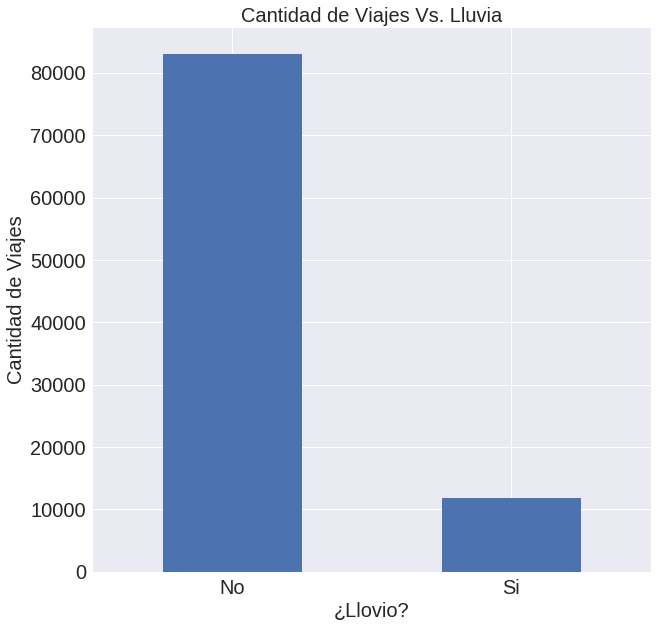

In [307]:
joined['lluvia'].value_counts().plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.xlabel('¿Llovio?', fontsize=20);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes Vs. Lluvia', fontsize=20);
plt.legend('');

Las observaciones que se hacen de este plot son:  
* Hay una diferencia de 70000 viajes a favor de los días en los que no llueve. Por ende, se puede decir que se viaja mucho más cuando no llueve.  
* Los 10000 viajes que se producen cuando llueve se pueden deber a que la intensidad de la lluvia es demasiado baja y, por lo tanto, los usuarios optan por seguir viajando.  

### 2.5.B) Duración promedio de los Viajes con Lluvia Vs. Duración promedio de los Viajes sin Lluvia

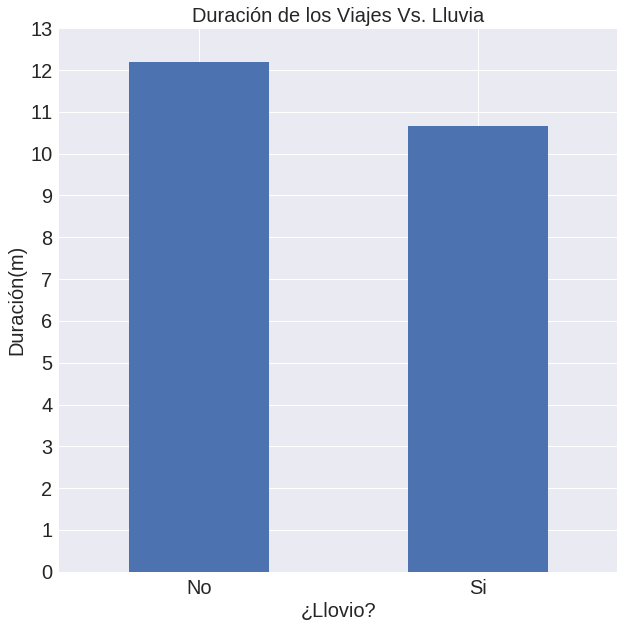

In [309]:
joined[['lluvia', 'duration_m']].groupby('lluvia').aggregate('mean').plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,14,1));
plt.xlabel('¿Llovio?', fontsize=20);
plt.ylabel('Duración(m)', fontsize=20)
plt.title('Duración de los Viajes Vs. Lluvia', fontsize=20);
plt.legend('');

Es interesante lo que se puede obtener de este plot. Si bien la diferencia de viajes entre los días con lluvia y los días sin lluvia es muy grande, la diferencia en duraciones promedio es muy pequeña, aproximadamente 1 minuto. Esto vuelve a indicar que los viajes que se realizan cuando llueve se producirían cuando la intensidad es baja.

### 2.5.C) Conclusión de Viajes y Lluvia

La conclusión de esta serie de plots es muy clara, se realizan más viajes cuando no llueve que cuando llueve. Pero las duraciones de los viajes que se realizan cuando llueve son cercanas a las duraciones de un viaje promedio cuando no llueve. Como se menciono previamente, una posible causa por la cual se presenta esto, es que los viajes se realizan cuando la lluvia tiene una intensidad baja.